# Simulating reviewing with synthetic priors

## Loading packages and importing dataset

In [ ]:
import asreview
import pandas as pd
from asreview.models.balancers import Balanced
from asreview.models.classifiers import SVM
from asreview.models.feature_extractors import Tfidf
from asreview.models.queriers import Random, TopDown, Max
from asreview.models.stoppers import IsFittable
from asreview.metrics import loss
from asreview.metrics import ndcg
from asreviewcontrib.insights import algorithms
from asreviewcontrib.insights import metrics 
import numpy as np
import random
from matplotlib import pyplot as plt
import pathlib as Path
import os
from dotenv import load_dotenv
import dspy
from openai import OpenAI
import litellm


In [ ]:
name_dataset = 'Brouwer_2019'

dataset_path = f'C:\\Users\\timov\\Desktop\\Utrecht\\Utrecht\\MSBBSS\\thesis_timo\\Synergy\\synergy_dataset\\{name_dataset}.csv'
output_path = output_path = os.path.join(os.getcwd(), f"output\{name_dataset}")
stimulus_for_llm = ['inclusion_criteria', 'exclusion_criteria'] # specify which columns from the snyergy metadata to use as stimulus for LLM

In [201]:
os.makedirs(output_path, exist_ok=True)
print("Directory created at:", output_path)

Directory created at: c:\Users\timov\Desktop\Utrecht\Utrecht\MSBBSS\thesis_timo\notebooks\output\Brouwer_2019


In [ ]:
dataset = pd.read_csv(dataset_path)
len(dataset)

38114

## Generating and selecting priors

### Importing research specific stimulus

In [203]:
synergy_metadata = pd.read_excel(r'C:\Users\timov\Desktop\Utrecht\Utrecht\MSBBSS\thesis_timo\Synergy\synergy_dataset_overview.xlsx')

np.where(synergy_metadata['dataset_ID'].to_numpy() == name_dataset)

row_of_dataset = synergy_metadata.index[synergy_metadata['dataset_ID'].eq(name_dataset)]

int_of_row = int(row_of_dataset[0])

criteria = synergy_metadata.loc[int_of_row, stimulus_for_llm]
criteria

inclusion_criteria    Criteria for studies to be included in the rev...
exclusion_criteria    Studies that solely included people with a fir...
Name: 2, dtype: object

### Generating synthetic priors

In [204]:
load_dotenv()  # Load environment variables from .env file

lm = dspy.LM("openai/gpt-4o-mini", temperature=0.7)
dspy.configure(lm=lm)

class MakeAbstract(dspy.Signature):
    """Generate a fake abstract based on search terms and whether it should be included or not."""
    criteria: str = dspy.InputField(desc="The inclusion or exclusion criteria of the review")
    label_included: int = dspy.InputField(desc="1 if it would perfectly fit the review; 0 if it would be returned by the given search terms but not fit the review")
    nonce: str = dspy.InputField() 
    jsonl: str = dspy.OutputField(desc='One-line JSON object: {"doi":"None","title":"...","abstract":"...","label_included":"1/0","reasoning":"..."}')

make_abstract = dspy.ChainOfThought(MakeAbstract)

In [205]:
df_generated = pd.DataFrame()
n_abstracts = 5

# loop to generate multiple abstracts
for i in range(n_abstracts):
    
    #generate included abstract
    included = make_abstract(
        criteria = criteria['inclusion_criteria'],
        label_included=1,
        nonce=f"run-{i}",
        extra_instructions=""
    ).jsonl

    #generate excluded abstract
    excluded = make_abstract(
        criteria = criteria['exclusion_criteria'],
        label_included=0,
        nonce=f"run-{i}",
        extra_instructions=""
    ).jsonl

    #combine included and excluded abstracts into one pandas dataframe
    data = [included, excluded]
    data_dicts = [eval(item) for item in data]
    df_generated = pd.concat([df_generated, pd.DataFrame(data_dicts)], ignore_index=True)
    df_generated['label_included'] = df_generated['label_included'].astype(int)
    

df_generated

,doi,title,abstract,label_included,reasoning
0,None,Predictors of Relapse in Major Depressive Diso...,This longitudinal study examines the factors p...,1,"The study meets all inclusion criteria, includ..."
1,None,Examining Depression in Older Adults: A Focus ...,This study explores the prevalence and treatme...,0,The study includes individuals with first onse...
2,None,Longitudinal Study on Predictors of Relapse in...,This study investigates the predictors of rela...,1,"The study meets all the inclusion criteria, fo..."
3,None,Examining the Impact of Depression in Older Ad...,This study analyzes the prevalence and impact ...,0,The study includes participants with late-onse...
4,None,Predictors of Relapse in Major Depressive Diso...,This longitudinal study examines the predictor...,1,This study investigates the predictors of rela...
5,None,Exploring the Impact of Major Depressive Disor...,This study examines the prevalence and treatme...,0,The study discusses MDD but does not meet the ...
6,None,Longitudinal Study of Predictors for Relapse i...,This longitudinal study investigates the predi...,1,The study meets all the inclusion criteria out...
7,None,Exploring Depression Across Lifespan: A Study ...,This study examines the prevalence and charact...,0,The study includes individuals with late-life ...
8,None,Longitudinal Predictors of Relapse in Major De...,This longitudinal study investigates the predi...,1,This study meets all the inclusion criteria ou...
9,None,Exploring the Variability of Major Depressive ...,This study investigates the clinical character...,0,The study does not exclusively focus on first ...


In [206]:
# Concatenate the existing DataFrame with the fake row DataFrame
dataset_llm = pd.concat([dataset, df_generated], ignore_index=True)

## Create an array of integers with index of the fake_row_df in dataset_llm
llm_prior_idx = np.array(range(len(dataset), len(dataset_llm)))

# save dataset with LLM priors to file to output_path and with dataset specific name
dataset_llm_path = Path.Path(output_path) / f'{name_dataset}_llm_priors.csv' 
dataset_llm.to_csv(dataset_llm_path, index=False)

print("Indices of LLM-generated priors in the new dataset:", llm_prior_idx)

Indices of LLM-generated priors in the new dataset: [38114 38115 38116 38117 38118 38119 38120 38121 38122 38123]


### Randomly select one relevant and one irrelevant paper

In [207]:
indices_w0 = np.where(dataset['label_included'].to_numpy() == 0)[0]
indices_w1 = np.where(dataset['label_included'].to_numpy() == 1)[0]

if len(indices_w0) == 0 or len(indices_w1) == 0:
    raise ValueError("Need at least one row with label_included==0 and one with ==1.")

# select two random indices from indices_w0 and one from indices_w1
i0 = random.sample(list(indices_w0), 1)
i1 = random.sample(list(indices_w1), 1)

#convert to int
i0 = [int(i) for i in i0]
i1 = [int(i) for i in i1]

print(f"Using prior indices {i0} (label 0) and {i1} (label 1) from original dataset as llm priors.")
minimal_prior_idx = [i0, i1]

#convert to flat list
minimal_prior_idx = [item for sublist in minimal_prior_idx for item in sublist]
minimal_prior_idx


Using prior indices [14339] (label 0) and [15365] (label 1) from original dataset as llm priors.


[14339, 15365]

## Simulation time!

In [208]:
tfidf_kwargs = {
    "ngram_range": (1, 2),
    "sublinear_tf": True,
    "max_df": 0.95,
    "min_df": 1,
}

alc_no_prior = [
    asreview.ActiveLearningCycle(querier=TopDown(), stopper=IsFittable()),
    asreview.ActiveLearningCycle(
        querier=Max(),
        classifier=SVM(C=0.11, loss="squared_hinge"),
        balancer=Balanced(ratio=9.8),
        feature_extractor=Tfidf(**tfidf_kwargs),
    )
]

alc = [
    asreview.ActiveLearningCycle(
        querier=Max(),
        classifier=SVM(C=0.11, loss="squared_hinge"),
        balancer=Balanced(ratio=9.8),
        feature_extractor=Tfidf(**tfidf_kwargs),
    )
]

# Run simulation with minimal priors
simulate_minimal = asreview.Simulate(X=dataset, labels=dataset["label_included"], cycles=alc)
simulate_minimal.label(minimal_prior_idx)
simulate_minimal.review()

# Run simulation with LLM priors
simulate_llm = asreview.Simulate(X=dataset_llm, labels=dataset_llm["label_included"], cycles=alc)
simulate_llm.label(llm_prior_idx)
simulate_llm.review()

# Run simulation without priors (random start)
simulate_no_priors = asreview.Simulate(X=dataset, labels=dataset["label_included"], cycles=alc_no_prior)
simulate_no_priors.review()

# This line drops priors. To access the dataframe before this, just use simulate._results
df_results_minimal = simulate_minimal._results.dropna(axis=0, subset="training_set")
df_results_llm = simulate_llm._results.dropna(axis=0, subset="training_set")
df_results_no_priors = simulate_no_priors._results.dropna(axis=0, subset="training_set")



Loss: 0.004
NDCG: 0.616



Loss: 0.004
NDCG: 0.723



Loss: 0.015
NDCG: 0.455


In [209]:
def pad_labels(labels, num_priors, num_records):
    return pd.Series(
        labels.tolist() + np.zeros(num_records - len(labels) - num_priors).tolist()
    )

In [339]:
padded_labels_minimal = pad_labels(df_results_minimal["label"].reset_index(drop=True), len(minimal_prior_idx), len(dataset))
padded_labels_llm = pad_labels(df_results_llm["label"].reset_index(drop=True), len(llm_prior_idx), len(dataset_llm))
padded_labels_no_priors = pad_labels(df_results_no_priors["label"].reset_index(drop=True), 0, len(dataset))

In [ ]:
# concatenate the three cumulative sum results in one dataframe for adding metadata and plotting

df_cumsum = pd.DataFrame({
    'Minimal Priors': padded_labels_minimal.cumsum(),
    'LLM Priors': padded_labels_llm.cumsum(),
    'No Priors': padded_labels_no_priors.cumsum()
})

df_cumsum

# save cumulative sum dataframe to output_path
df_cumsum_path = Path.Path(output_path) / 'cumsum_results.csv' 
df_cumsum.to_csv(df_cumsum_path, index=False)
df_cumsum

,Minimal Priors,LLM Priors,No Priors
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,2.0,0.0
...,...,...,...
38109,61.0,62.0,62.0
38110,61.0,62.0,62.0
38111,61.0,62.0,62.0
38112,NaN,62.0,62.0


### Plot

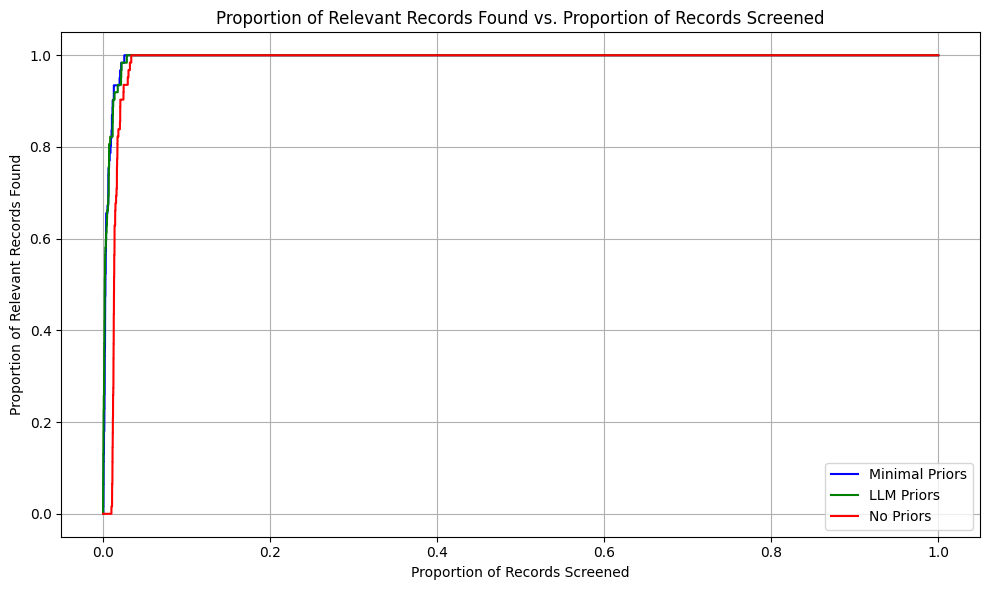

<Figure size 640x480 with 0 Axes>

In [ ]:
# generate a plot with scaled cumulative sum (divided by total number of relevant records in dataset)
plt.figure(figsize=(10, 6))
plt.step(np.arange(1, len(df_cumsum['Minimal Priors'].dropna())+1) / len(df_cumsum['Minimal Priors'].dropna()), (df_cumsum['Minimal Priors'] / (dataset['label_included'].sum() - dataset['label_included'].iloc[minimal_prior_idx].sum())).dropna(), label='Minimal Priors', color='blue', where='post')
plt.step(np.arange(1, len(df_cumsum['LLM Priors'].dropna())+1) / len(df_cumsum['LLM Priors'].dropna()), (df_cumsum['LLM Priors'] / dataset['label_included'].sum()).dropna(), label='LLM Priors', color='green', where='post')
plt.step(np.arange(1, len(df_cumsum['No Priors'].dropna())+1) / len(df_cumsum['No Priors'].dropna()), (df_cumsum['No Priors'] / (dataset['label_included'].sum())).dropna(), label='No Priors', color='red', where='post')
plt.xlabel('Proportion of Records Screened')
plt.ylabel('Proportion of Relevant Records Found')
plt.title('Proportion of Relevant Records Found vs. Proportion of Records Screened')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# save plot to output_path
plot_path = Path.Path(output_path) / 'recall_plot.png'
plt.savefig(plot_path)

### Metrics

In [351]:
nrr_minimal = loss(list(padded_labels_minimal))
nrr_llm = loss(list(padded_labels_llm))
nrr_no_priors = loss(list(padded_labels_no_priors))

In [352]:
ndcg_score_minimal =  ndcg(list(padded_labels_minimal))
ndcg_score_llm = ndcg(list(padded_labels_llm))
ndcg_score_no_priors = ndcg(list(padded_labels_no_priors))


In [360]:
tdd_threshold = 100

def tdd_at(results, threshold):
    all_tdd = metrics._time_to_discovery(results['record_id'], results['label'])
    count = sum(iter_idx <= threshold for _, iter_idx in all_tdd)
    return all_tdd, count

td_minimal = tdd_at(df_results_minimal, tdd_threshold)[1]
td_llm = tdd_at(df_results_llm, tdd_threshold)[1]
td_no_priors = tdd_at(df_results_no_priors, tdd_threshold)[1]

In [330]:
atd_minimal = metrics._average_time_to_discovery(tdd_at(df_results_minimal, tdd_threshold)[0])
atd_llm = metrics._average_time_to_discovery(tdd_at(df_results_llm, tdd_threshold)[0])
atd_no_priors = metrics._average_time_to_discovery(tdd_at(df_results_no_priors, tdd_threshold)[0])


In [365]:
threshold = .95

all_wss_minimal = algorithms._wss_values(padded_labels_minimal)
all_wss_llm = algorithms._wss_values(padded_labels_llm)
all_wss_no_priors = algorithms._wss_values(padded_labels_no_priors)

idx_minimal = np.searchsorted(all_wss_minimal[0], 0.95, side="right") - 1
idx_minimal = max(idx_minimal, 0)

idx_llm = np.searchsorted(all_wss_llm[0], 0.95, side="right") - 1
idx_llm = max(idx_llm, 0)

idx_no_priors = np.searchsorted(all_wss_no_priors[0], 0.95, side="right") - 1
idx_no_priors = max(idx_no_priors, 0)


In [ ]:
metric_names = ["nrr", "ndcg", "td", "atd", "wss"]

df_metrics = (
    pd.DataFrame({
        "metric": metric_names,
        'Minimal Priors': [nrr_minimal, ndcg_score_minimal, td_minimal, atd_minimal, all_wss_minimal[1][idx_minimal]],
        'LLM Priors': [nrr_llm, ndcg_score_llm, td_llm, atd_llm, all_wss_llm[1][idx_llm]],
        'No Priors': [nrr_no_priors, ndcg_score_no_priors, td_no_priors, atd_no_priors, all_wss_no_priors[1][idx_no_priors]]
    })
    .set_index("metric")
)

# save cumulative sum dataframe to output_path
df_metrics_path = Path.Path(output_path) / 'metrics.csv' 
df_metrics.to_csv(df_metrics_path, index=False)
df_metrics

,Minimal Priors,LLM Priors,No Priors
metric,,,
nrr,0.004488,0.004333,0.014555
ndcg,0.616018,0.722953,0.455024
td,29.000000,35.000000,0.000000
atd,201.754098,196.370968,585.338710
wss,0.913282,0.909771,0.902739
